In [1]:
%matplotlib inline
import requests
import datetime as dt 
import pandas as pd
import geopandas as gpd
import contextily as ctx 
from shapely.geometry import MultiPolygon, Polygon, box
from shapely.ops import orient

In [2]:
doi = '10.3334/ORNLDAAC/2056'# GEDI L4A DOI 

# CMR API base url
cmrurl='https://cmr.earthdata.nasa.gov/search/' 

doisearch = cmrurl + 'collections.json?doi=' + doi
response = requests.get(doisearch)
response.raise_for_status()
concept_id = response.json()['feed']['entry'][0]['id']

print(concept_id)

C2237824918-ORNL_CLOUD


In [3]:
# Bounding box
bound = bound = (32.4, -10, 38.4, -4)

# time bound
start_date = dt.datetime(2020, 7, 1) # specify your own start date
end_date = dt.datetime(2023, 3, 15)  # specify your end start date

In [4]:
# CMR formatted start and end times
dt_format = '%Y-%m-%dT%H:%M:%SZ'
temporal_str = start_date.strftime(dt_format) + ',' + end_date.strftime(dt_format)

# CMR formatted bounding box
bound_str = ','.join(map(str, bound))

page_num = 1
page_size = 2000 # CMR page size limit

granule_arr = []

while True:
    
    # defining parameters
    cmr_param = {
        "collection_concept_id": concept_id, 
        "page_size": page_size,
        "page_num": page_num,
        "temporal": temporal_str,
        "bounding_box[]": bound_str
    }
    
    granulesearch = cmrurl + 'granules.json'

    response = requests.get(granulesearch, params=cmr_param)
    response.raise_for_status()
    granules = response.json()['feed']['entry']
    
    if granules:
        for g in granules:
            granule_url = ''
            granule_poly = ''
            
            # read file size
            granule_size = float(g['granule_size'])
            
            # reading bounding geometries
            if 'polygons' in g:
                polygons= g['polygons']
                multipolygons = []
                for poly in polygons:
                    i=iter(poly[0].split (" "))
                    ltln = list(map(" ".join,zip(i,i)))
                    multipolygons.append(Polygon([[float(p.split(" ")[1]), float(p.split(" ")[0])] for p in ltln]))
                granule_poly = MultiPolygon(multipolygons)
            
            # Get URL to HDF5 files
            for links in g['links']:
                if 'title' in links and links['title'].startswith('Download') \
                and links['title'].endswith('.h5'):
                    granule_url = links['href']
            granule_arr.append([granule_url, granule_size, granule_poly])
               
        page_num += 1
    else: 
        break

# adding bound as the last row into the dataframe
# we will use this later in the plot
b = list(bound)
granule_arr.append(['bound', 0, box(b[0], b[1], b[2], b[3])]) 

# creating a pandas dataframe
l4adf = pd.DataFrame(granule_arr, columns=["granule_url", "granule_size", "granule_poly"])

# Drop granules with empty geometry
l4adf = l4adf[l4adf['granule_poly'] != '']

print ("Total granules found: ", len(l4adf.index)-1)
print ("Total file size (MB): ", l4adf['granule_size'].sum())

Total granules found:  771
Total file size (MB):  148249.434809


In [5]:
links = l4adf['granule_url'].head(5)
print(links[2])

https://data.ornldaac.earthdata.nasa.gov/protected/gedi/GEDI_L4A_AGB_Density_V2_1/data/GEDI04_A_2020185200613_O08828_01_T03758_02_002_02_V002.h5


,granule_url,granule_size,granule_poly,geometry
0,https://data.ornldaac.earthdata.nasa.gov/prote...,166.702108,"MULTIPOLYGON (((27.367485 0.130105, 29.524477 ...","MULTIPOLYGON (((3046534.494 14483.235, 3286649..."
1,https://data.ornldaac.earthdata.nasa.gov/prote...,109.961799,"MULTIPOLYGON (((33.3079376 0.0724, 35.4645195 ...","MULTIPOLYGON (((3707822.653 8059.533, 3947892...."
2,https://data.ornldaac.earthdata.nasa.gov/prote...,236.020330,"MULTIPOLYGON (((-3.674257 -41.2950134, 0.16965...","MULTIPOLYGON (((-409016.418 -5055953.941, 1888..."
3,https://data.ornldaac.earthdata.nasa.gov/prote...,246.515833,"MULTIPOLYGON (((-4.4372029 -44.6604156, -0.120...","MULTIPOLYGON (((-493947.167 -5568218.366, -134..."
4,https://data.ornldaac.earthdata.nasa.gov/prote...,157.355906,"MULTIPOLYGON (((25.9657917 2.402776, 28.124519...","MULTIPOLYGON (((2890498.710 267554.235, 313080..."


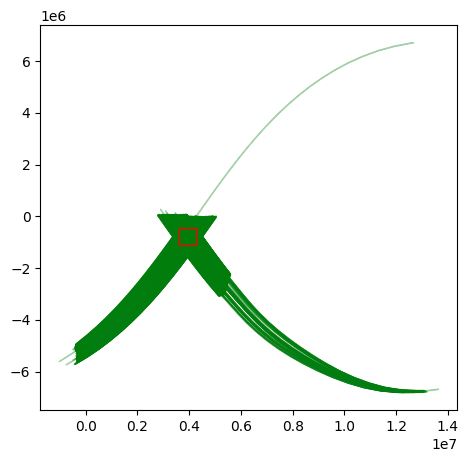

In [6]:
# creating a GeoDataFrame
gdf = gpd.GeoDataFrame(l4adf, geometry=l4adf.granule_poly)
# assigning CRS as WGS84
gdf.crs = "EPSG:4326"
# converting CRS to Web Mercator, the reference system of the contextily basemap
gdf_epsg3857 = gdf.to_crs(epsg=3857)
# plotting GEDI suborbits
ax = gdf_epsg3857[:-1].plot(figsize=(10, 5), alpha=0.3, edgecolor='green')
# plotting the bounding box (last row)
gdf_epsg3857[-1:].plot(ax=ax, facecolor='none', edgecolor='red')

gdf_epsg3857.head()

In [7]:
# drop duplicate URLs if any
l4a_granules = l4adf[:-1].drop_duplicates(subset=['granule_url'])
l4a_granules.to_csv('granules.txt', columns = ['granule_url'], index=False, header = False)

In [12]:
# Code to collect worldCover data
from terracatalogueclient import Catalogue 

# create catalogue object and authenticate 
catalogue = Catalogue().authenticate() 

# search for products in the WorldCover collection 
products = catalogue.get_products("urn:eop:VITO:ESA_WorldCover_10m_2020_V1") 

# download the products to the given directory 
catalogue.download_products(products, "downloads") 

from shapely.geometry import Polygon 
from terracatalogueclient import Catalogue 

### Authenticate to the Terrascope platform (registration required) 
# create catalogue object and authenticate interactively with a browser 
catalogue = Catalogue().authenticate()  

# or authenticate with username and password 
# catalogue = catalogue.authenticate_non_interactive(username, password) 

### Filter catalogue 
# search for all products in the WorldCover collection 
# products = catalogue.get_products("urn:eop:VITO:ESA_WorldCover_10m_2020_V1") 

# or filter to a desired geometry, by providing it as an argument to get_products 

geometry = Polygon.from_bounds(*bound) 
products = catalogue.get_products("urn:eop:VITO:ESA_WorldCover_10m_2020_V1", geometry=geometry) 

### Download 
# download the products to the given directory 
catalogue.download_products(products, "downloads") 

ModuleNotFoundError: No module named 'terracatalogueclient'